In [66]:
import pandas as pd
import numpy as np
from intervaltree import IntervalTree
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import os

In [67]:
# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords


In [68]:
def load_and_process_data(peaks_file: str, dexseq_file: str, padj_threshold: float = 0.05) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load and process the peaks and DEXSeq data files.
    
    Args:
        peaks_file: Path to peaks CSV file
        dexseq_file: Path to DEXSeq results CSV file
        padj_threshold: Adjusted p-value threshold for significance
    
    Returns:
        Tuple of processed peaks and DEXSeq DataFrames
    """
    # Load data
    peaks_df = pd.read_csv(peaks_file)
    dexseq_df = pd.read_csv(dexseq_file)
    
    # Filter significant DEXSeq results
    dexseq_df = dexseq_df[dexseq_df['padj'] < padj_threshold].copy()
    
    return peaks_df, dexseq_df

In [69]:

def create_interval_tree(peaks_df: pd.DataFrame) -> IntervalTree:
    """
    Create an interval tree from peaks data for efficient overlap detection.
    """
    tree = IntervalTree()
    for _, row in peaks_df.iterrows():
        tree.addi(row['start'], row['end'], {
            'seqnames': row['seqnames'],
            'peak_id': row.name,
            'peak_name': row['peak_name']
        })
    return tree

In [70]:
def find_overlaps(dexseq_df: pd.DataFrame, peaks_tree: IntervalTree) -> List[dict]:
    """
    Find overlaps between DEXSeq exons and peaks.
    """
    overlaps = []
    
    for _, exon in dexseq_df.iterrows():
        chr_name = exon['genomicData.seqnames']
        start = exon['genomicData.start']
        end = exon['genomicData.end']
        
        # Find overlapping peaks
        overlapping = peaks_tree.overlap(start, end)
        
        for overlap in overlapping:
            if overlap.data['seqnames'] == chr_name:
                overlaps.append({
                    'exon_id': exon['featureID'],
                    'peak_id': overlap.data['peak_id'],
                    'peak_name': overlap.data['peak_name'],
                    'dexseq_name': exon['dexseq_name'],
                    'chromosome': chr_name,
                    'overlap_start': max(start, overlap.begin),
                    'overlap_end': min(end, overlap.end),
                    'overlap_length': min(end, overlap.end) - max(start, overlap.begin),
                    'exon_log2fc': exon['log2fold_treated_control'],
                    'exon_padj': exon['padj']
                })
    
    return overlaps

In [71]:
def plot_overlap_lengths(overlaps_df: pd.DataFrame, ax):
    """Plot distribution of overlap lengths."""
    sns.histplot(data=overlaps_df, x='overlap_length', bins=30, ax=ax)
    ax.set_title('Distribution of Overlap Lengths')
    ax.set_xlabel('Overlap Length (bp)')

def plot_fc_correlation(overlaps_df: pd.DataFrame, peaks_df: pd.DataFrame, ax):
    """Plot correlation between exon and peak fold changes."""
    peak_fc = peaks_df.loc[overlaps_df['peak_id']]['L2FC'].values
    sns.scatterplot(data=overlaps_df, x='exon_log2fc', y=peak_fc, ax=ax)
    ax.set_title('Exon Log2FC vs Peak Log2FC')
    ax.set_xlabel('Exon Log2FC')
    ax.set_ylabel('Peak Log2FC')
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

def plot_chromosome_distribution(overlaps_df: pd.DataFrame, ax):
    """Plot distribution of overlaps across chromosomes."""
    overlaps_df['chromosome'].value_counts().plot(kind='bar', ax=ax)
    ax.set_title('Overlaps by Chromosome')
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('Number of Overlaps')

def visualize_overlaps(overlaps_df: pd.DataFrame, peaks_df: pd.DataFrame, dexseq_df: pd.DataFrame):
    """
    Create visualizations for the overlap analysis.
    """
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)
    
    # 1. Distribution of overlap lengths
    ax1 = fig.add_subplot(gs[0, 0])
    plot_overlap_lengths(overlaps_df, ax1)
    
    # 2. Scatter plot of exon log2FC vs peak fold change
    ax2 = fig.add_subplot(gs[0, 1])
    plot_fc_correlation(overlaps_df, peaks_df, ax2)
    
    # 3. Chromosome distribution of overlaps
    ax3 = fig.add_subplot(gs[1, 0])
    plot_chromosome_distribution(overlaps_df, ax3)
    
    plt.tight_layout()
    return fig

In [72]:
# Example usage
peaks_file = "./DATA/Peak.csv"
dexseq_file = "./output/dexseq_results_PW1_vs_combined_controls_cleaned_permisive.csv"
output_prefix = "./output/overlap_analysis"

# overlaps_df = main(peaks_file, dexseq_file, output_prefix)

In [73]:
# Load and process data
peaks_df, dexseq_df = load_and_process_data(peaks_file, dexseq_file)

In [74]:
pd.set_option('display.max_columns', None)
peaks_df.head()

,Row.names,seqnames,start,end,width,annotation,geneChr,geneStart,geneEnd,geneLength,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME,ASE1,ASE2,GeneID,Ctrl.bam,V5.bam,difference,FC,L2FC
0,chr15:25051475-25051745,chr15,25051475.0,25051745.0,271.0,Promoter (<=1kb),15.0,25051477.0,25051571.0,95.0,100033413.0,ENST00000384335.1,0.0,ENSG00000207063,SNORD116-1,"small nucleolar RNA, C/D box 116-1",NaN,NaN,controlledV5_peak_329,0,961,961,961.0,9.908392621
1,chr2:74154059-74154316,chr2,74154059.0,74154316.0,258.0,3' UTR,2.0,74148079.0,74151952.0,3874.0,100507171.0,ENST00000656407.1,5980.0,ENSG00000225439,BOLA3-DT,BOLA3 divergent transcript,NaN,NaN,controlledV5_peak_575,0,31,31,31.0,4.95419631
2,chr17:21198291-21198758,chr17,21198291.0,21198758.0,468.0,3' UTR,17.0,21184385.0,21193265.0,8881.0,25979.0,ENST00000581463.1,13906.0,ENSG00000109016,DHRS7B,dehydrogenase/reductase 7B,NaN,NaN,controlledV5_peak_423,0,20,20,20.0,4.321928095
3,chr17:744815-745029,chr17,744815.0,745029.0,215.0,3' UTR,17.0,747844.0,752038.0,4195.0,50628.0,ENST00000574958.1,7009.0,ENSG00000179409,GEMIN4,gem nuclear organelle associated protein 4,NaN,NaN,controlledV5_peak_403,0,18,18,18.0,4.169925001
4,chr10:27134830-27135032,chr10,27134830.0,27135032.0,203.0,Promoter (1-2kb),10.0,27123547.0,27136337.0,12791.0,10730.0,ENST00000463270.1,1305.0,ENSG00000136758,YME1L1,YME1 like 1 ATPase,NaN,NaN,controlledV5_peak_142,0,17,17,17.0,4.087462841


In [75]:
peaks_df = peaks_df.rename(columns={"Row.names": "peak_name"})

In [76]:
print(list(peaks_df['seqnames'][:5]))
print(list(peaks_df.iloc[:5].index))

['chr15', 'chr2', 'chr17', 'chr17', 'chr10']
[0, 1, 2, 3, 4]


In [77]:
dexseq_df.head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
0,ENSG00000000003.14:E001,ENSG00000000003.14,E001,120.179059,0.011335,2984.629607,0.000000e+00,0.000000e+00,16.638651,14.784409,-0.479628,chrX,100627109,100628669,1561,-,123,139,86,83,106,98,119,182,189
1,ENSG00000000003.14:E002,ENSG00000000003.14,E002,1270.531715,0.006461,396.260920,8.975001e-87,1.213046e-86,30.813401,30.602511,-0.045605,chrX,100628670,100629986,1317,-,1007,1237,687,906,1184,974,1419,2630,2220
2,ENSG00000000003.14:E003,ENSG00000000003.14,E003,444.716283,0.008585,1806.024855,0.000000e+00,0.000000e+00,23.933712,23.706313,-0.051117,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802
3,ENSG00000000003.14:E004,ENSG00000000003.14,E004,1.981576,0.022925,3109.695893,0.000000e+00,0.000000e+00,2.492781,2.656301,0.185495,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4
4,ENSG00000000003.14:E005,ENSG00000000003.14,E005,358.929210,0.007125,2538.819848,0.000000e+00,0.000000e+00,22.574929,22.337963,-0.053991,chrX,100632485,100632568,84,-,289,347,196,233,334,297,393,719,654


In [78]:
dexseq_df = dexseq_df.rename(columns={"Unnamed: 0": "dexseq_name"})

In [79]:
dexseq_df.columns

Index(['dexseq_name', 'groupID', 'featureID', 'exonBaseMean', 'dispersion',
       'stat', 'pvalue', 'padj', 'control', 'treated',
       'log2fold_treated_control', 'genomicData.seqnames', 'genomicData.start',
       'genomicData.end', 'genomicData.width', 'genomicData.strand',
       'countData.EDO_1', 'countData.EDO_2', 'countData.EDO_3',
       'countData.ND1_1', 'countData.ND1_2', 'countData.ND1_3',
       'countData.PW1_1', 'countData.PW1_2', 'countData.PW1_3'],
      dtype='object')

In [80]:
print(list(dexseq_df['genomicData.seqnames'][:5]))
print(list(dexseq_df['featureID'][:5]))


['chrX', 'chrX', 'chrX', 'chrX', 'chrX']
['E001', 'E002', 'E003', 'E004', 'E005']


In [81]:
# Create interval tree for efficient overlap detection
peaks_tree = create_interval_tree(peaks_df)

In [82]:
list(peaks_tree.items())[:10]



[Interval(44065741.0, 44065975.0, {'seqnames': 'chr2', 'peak_id': 691, 'peak_name': 'chr2:44065741-44065975'}),
 Interval(2431546.0, 2431734.0, {'seqnames': 'chr19', 'peak_id': 619, 'peak_name': 'chr19:2431546-2431734'}),
 Interval(75321808.0, 75322308.0, {'seqnames': 'chr15', 'peak_id': 1085, 'peak_name': 'chr15:75321808-75322308'}),
 Interval(253490.0, 253707.0, {'seqnames': 'chr10', 'peak_id': 37, 'peak_name': 'chr10:253490-253707'}),
 Interval(47783878.0, 47784227.0, {'seqnames': 'chr12', 'peak_id': 389, 'peak_name': 'chr12:47783878-47784227'}),
 Interval(41604043.0, 41604252.0, {'seqnames': 'chr22', 'peak_id': 785, 'peak_name': 'chr22:41604043-41604252'}),
 Interval(1787781.0, 1788035.0, {'seqnames': 'chr16', 'peak_id': 718, 'peak_name': 'chr16:1787781-1788035'}),
 Interval(19378387.0, 19378889.0, {'seqnames': 'chr9', 'peak_id': 1063, 'peak_name': 'chr9:19378387-19378889'}),
 Interval(37925659.0, 37925853.0, {'seqnames': 'chr22', 'peak_id': 449, 'peak_name': 'chr22:37925659-379258

In [83]:
# Find overlaps
overlaps = find_overlaps(dexseq_df, peaks_tree)
overlaps_df = pd.DataFrame(overlaps)

In [84]:
overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,overlap_start,overlap_end,overlap_length,exon_log2fc,exon_padj
0,E007,474,chr17:47132254-47132464,ENSG00000004897.12:E007,chr17,47132257.0,47132374.0,117.0,-0.094016,0.000000e+00
1,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,57428714.0,57428937.0,223.0,-0.207524,0.000000e+00
2,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,57428938.0,57428958.0,20.0,-0.248556,0.000000e+00
3,E011,160,chr7:107160282-107160602,ENSG00000005249.13:E011,chr7,107160282.0,107160602.0,320.0,-0.141606,4.551355e-23
4,E031,395,chr16:3850321-3850506,ENSG00000005339.14:E031,chr16,3850321.0,3850506.0,185.0,0.036842,7.307589e-206


In [85]:
overlaps_df.shape

(981, 10)

In [86]:
# Save overlaps to file
overlaps_df.to_csv(f"{output_prefix}_overlaps.csv", index=False)

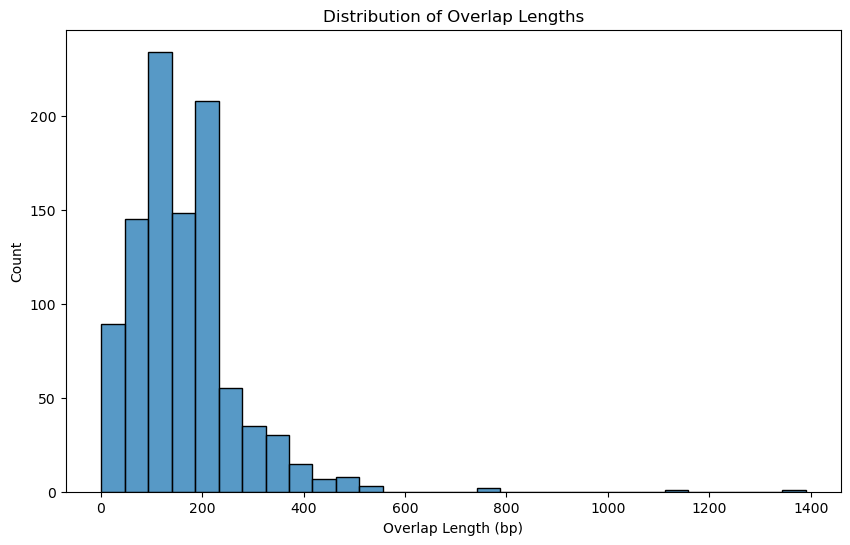

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_overlap_lengths(overlaps_df, ax)


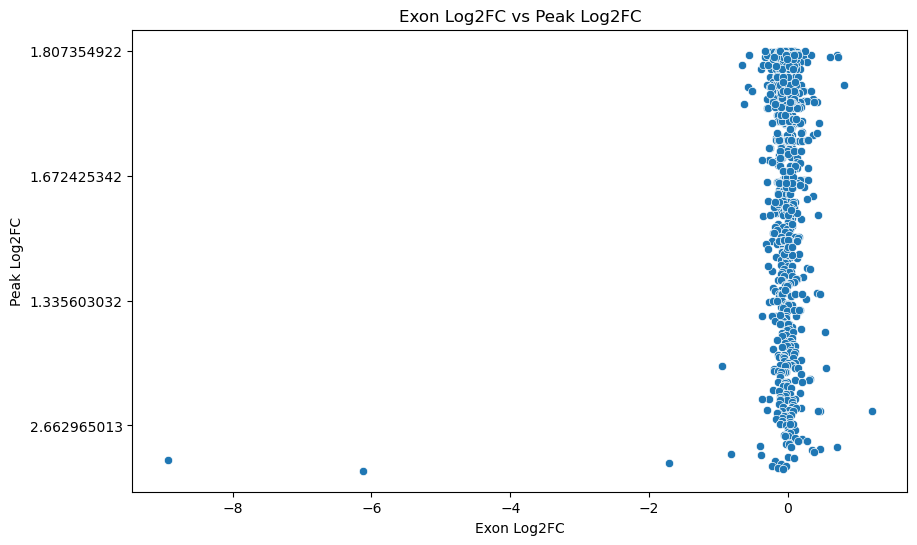

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_fc_correlation(overlaps_df, peaks_df, ax)

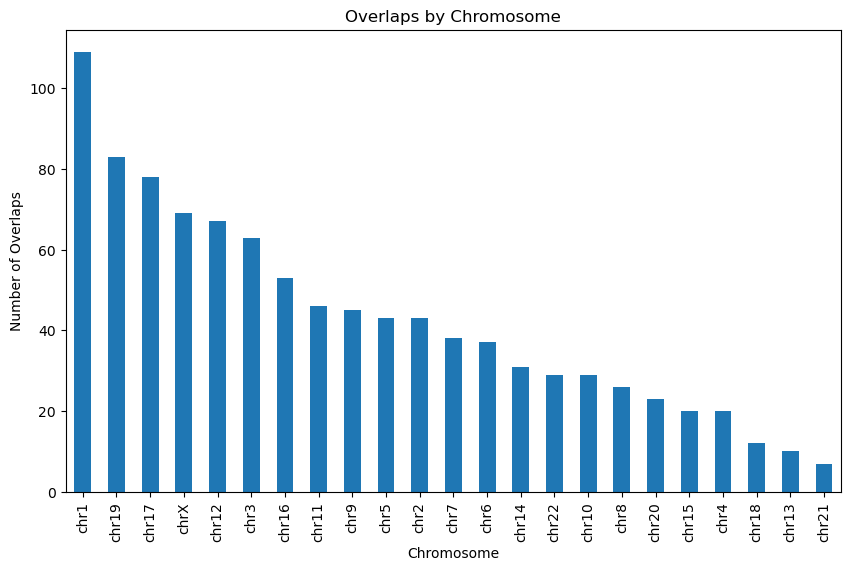

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_chromosome_distribution(overlaps_df, ax)

In [90]:
total_peaks = len(peaks_df)
total_exons = len(dexseq_df)
peaks_with_overlaps = len(overlaps_df['peak_id'].unique())
exons_with_overlaps = len(overlaps_df['exon_id'].unique())

print(f"Total Peaks: {total_peaks}")
print(f"Total Diff. Expressed Exons: {total_exons}")
print(f"Peaks with Overlaps: {peaks_with_overlaps}")
print(f"Exons with Overlaps: {exons_with_overlaps}")
print(f"Total Overlap Events: {len(overlaps_df)}")

Total Peaks: 1136
Total Diff. Expressed Exons: 247028
Peaks with Overlaps: 697
Exons with Overlaps: 67
Total Overlap Events: 981


In [91]:
def find_overlaps2(dexseq_df: pd.DataFrame, peaks_tree: IntervalTree) -> List[dict]:
    """
    Find overlaps and nearby peaks for DEXSeq exons.
    Also calculates distance to nearest peak for non-overlapping cases.
    """
    results = []
    
    for index, exon in dexseq_df.iterrows():
        chr_name = exon['genomicData.seqnames']
        exon_start = exon['genomicData.start']
        exon_end = exon['genomicData.end']
        exon_center = (exon_start + exon_end) / 2
        
        # Extend search window by 10kb in each direction
        search_start = exon_start - 10000
        search_end = exon_end + 10000
        
        # Find peaks in extended window
        nearby = peaks_tree.overlap(search_start, search_end)
        if index == 0 and len(nearby) > 0:
            print(list(nearby))
        
        for peak in nearby:
            if peak.data['seqnames'] == chr_name:
                peak_center = (peak.begin + peak.end) / 2
                
                # Calculate distance (negative if peak is upstream, positive if downstream)
                distance = peak_center - exon_center
                
                # Calculate overlap (if any)
                overlap_start = max(exon_start, peak.begin)
                overlap_end = min(exon_end, peak.end)
                overlap_length = max(0, overlap_end - overlap_start)
                
                results.append({
                    'exon_id': exon['featureID'],
                    'peak_id': peak.data['peak_id'],
                    'peak_name': peak.data['peak_name'],
                    'dexseq_name': exon['dexseq_name'],
                    'chromosome': chr_name,
                    'distance_to_peak': distance,
                    'overlap_length': overlap_length,
                    'exon_log2fc': exon['log2fold_treated_control'],
                    'exon_padj': exon['padj']
                })
    
    return results

def plot_distance_vs_fc(overlaps_df: pd.DataFrame, ax):
    """Plot relationship between peak distance and exon fold change."""
    # Convert distance to kb for better visualization
    overlaps_df['distance_kb'] = overlaps_df['distance_to_peak'] / 1000
    
    # Create scatter plot
    sns.scatterplot(
        data=overlaps_df,
        x='distance_kb',
        y='exon_log2fc',
        alpha=0.5,
        ax=ax
    )
    
    # Add trend line
    sns.regplot(
        data=overlaps_df,
        x='distance_kb',
        y='exon_log2fc',
        scatter=False,
        color='red',
        ax=ax
    )
    
    ax.set_title('Exon Log2FC vs Distance to Peak')
    ax.set_xlabel('Distance to Peak (kb)')
    ax.set_ylabel('Exon Log2FC')
    
    # Add vertical line at x=0 to mark the exon position
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    # Add horizontal line at y=0 to mark no change in expression
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

def visualize_distance_analysis(overlaps_df: pd.DataFrame):
    """
    Create visualizations for the distance analysis.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Distance vs Fold Change scatter plot
    plot_distance_vs_fc(overlaps_df, ax1)
    
    # 2. Distribution of distances
    sns.histplot(
        data=overlaps_df,
        x='distance_to_peak',
        bins=50,
        ax=ax2
    )
    ax2.set_title('Distribution of Peak Distances')
    ax2.set_xlabel('Distance to Peak (bp)')
    
    plt.tight_layout()
    return fig

In [92]:
# # Find overlaps and distances
overlaps = find_overlaps2(dexseq_df, peaks_tree)
overlaps_df = pd.DataFrame(overlaps)

In [93]:
overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj
0,E001,641,chr2:37222376-37222562,ENSG00000003509.16:E001,chr2,-9199.0,0.0,-0.042174,0.0
1,E002,641,chr2:37222376-37222562,ENSG00000003509.16:E002,chr2,-9250.5,0.0,0.121151,0.0
2,E003,641,chr2:37222376-37222562,ENSG00000003509.16:E003,chr2,-9717.0,0.0,0.211989,0.0
3,E004,474,chr17:47132254-47132464,ENSG00000004897.12:E004,chr17,9837.0,0.0,-0.079177,0.0
4,E005,474,chr17:47132254-47132464,ENSG00000004897.12:E005,chr17,8436.0,0.0,-0.102252,0.0


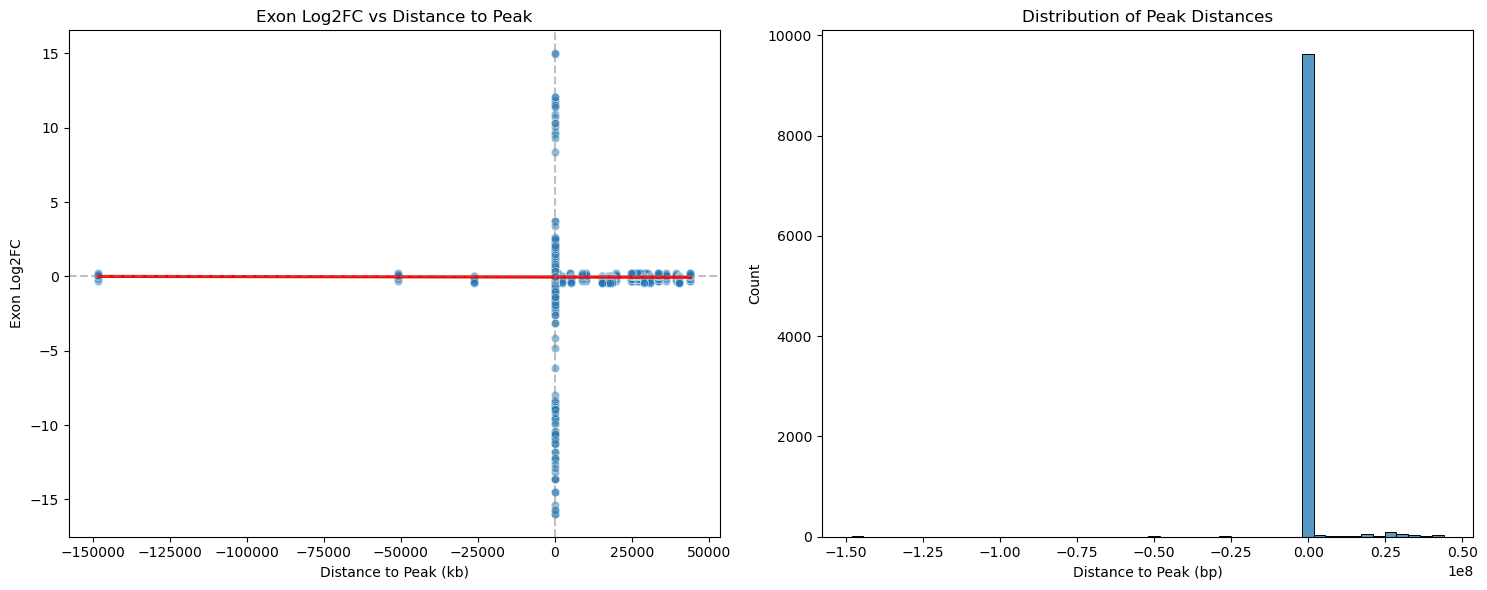

In [94]:
# Create visualization
fig = visualize_distance_analysis(overlaps_df)
plt.show()

# Complementarity analysis

In [95]:
%%script false --no-raise-error
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Align import PairwiseAligner
import requests
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

def get_exon_sequence(chromosome: str, start: int, end: int) -> str:
    """
    Fetch genomic sequence for given coordinates using Ensembl REST API.
    """
    server = "https://rest.ensembl.org"
    ext = f"/sequence/region/human/{chromosome}:{start}..{end}:1?"
    
    r = requests.get(server + ext, headers={"Content-Type": "text/plain"})
    if r.ok:
        return r.text
    return None

def analyze_als_complementarity(row: pd.Series, dexseq_df: pd.DataFrame, 
                              als1: str = 'AACATTCCTTGGAAAAG', 
                              als2: str = 'CGTCATTCTCATCGGAA') -> dict:
    """
    Analyze ALS complementarity for an exon and its neighbors.
    """
    print(f"Analyzing exon {row['exon_id']} from gene {row['dexseq_name'].split(':')[0]}")
    
    # Get current exon info
    current_gene = row['dexseq_name'].split(':')[0]
    current_exon_num = int(row['exon_id'].replace('E', ''))
    
    # Find neighboring exons from the same gene
    gene_exons = dexseq_df[dexseq_df['dexseq_name'].str.startswith(current_gene)].copy()
    gene_exons['exon_num'] = gene_exons['featureID'].str.replace('E', '').astype(int)
    gene_exons = gene_exons.sort_values('exon_num')
    
    # Get sequences for current and neighboring exons
    sequences = {}
    for idx, exon in gene_exons.iterrows():
        if abs(exon['exon_num'] - current_exon_num) <= 1:  # Current and immediate neighbors
            seq = get_exon_sequence(
                exon['genomicData.seqnames'],
                exon['genomicData.start'],
                exon['genomicData.end']
            )
            if seq:
                sequences[exon['featureID']] = seq
    
    # Analyze complementarity
    aligner = PairwiseAligner()
    aligner.match_score = 1
    aligner.mismatch_score = -1
    aligner.gap_score = -1
    
    results = {}
    for exon_id, seq in sequences.items():
        forward_seq = Seq(seq)
        reverse_seq = forward_seq.reverse_complement()
        
        # For ALS1
        als1_alignments = [
            aligner.align(forward_seq, Seq(als1)),
            aligner.align(reverse_seq, Seq(als1))
        ]
        best_als1_alignment = max(als1_alignments, key=lambda x: x[0].score)[0]
        
        # For ALS2
        als2_alignments = [
            aligner.align(forward_seq, Seq(als2)),
            aligner.align(reverse_seq, Seq(als2))
        ]
        best_als2_alignment = max(als2_alignments, key=lambda x: x[0].score)[0]
        
        results[exon_id] = {
            'als1_score': best_als1_alignment.score,
            'als2_score': best_als2_alignment.score,
            'als1_alignment': str(best_als1_alignment),
            'als2_alignment': str(best_als2_alignment),
            'sequence': seq
        }
    
    return results

def process_chunk(chunk_data):
    """
    Process a chunk of overlaps data in parallel
    """
    chunk, dexseq_df = chunk_data
    print(f"Processing chunk of size {len(chunk)}")
    results = []
    for idx, row in chunk.iterrows():
        try:
            als_analysis = analyze_als_complementarity(row, dexseq_df)
            # Check if we have results for the current exon
            if row['exon_id'] in als_analysis:
                row_dict = row.to_dict()
                row_dict.update({
                    'current_exon_als1_score': als_analysis[row['exon_id']]['als1_score'],
                    'current_exon_als2_score': als_analysis[row['exon_id']]['als2_score'],
                    'neighboring_exons_analysis': als_analysis
                })
                results.append(row_dict)
            else:
                print(f"Warning: No analysis results for exon {row['exon_id']}")
                # Add row with null values for ALS scores
                row_dict = row.to_dict()
                row_dict.update({
                    'current_exon_als1_score': None,
                    'current_exon_als2_score': None,
                    'neighboring_exons_analysis': {}
                })
                results.append(row_dict)
        except Exception as e:
            print(f"Error processing row with exon {row['exon_id']}: {str(e)}")
            # Add row with null values
            row_dict = row.to_dict()
            row_dict.update({
                'current_exon_als1_score': None,
                'current_exon_als2_score': None,
                'neighboring_exons_analysis': {}
            })
            results.append(row_dict)
            
    print(f"Completed chunk processing with {len(results)} results")
    return results

def analyze_overlaps_with_als(overlaps_df: pd.DataFrame, dexseq_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze ALS complementarity for all overlapping exons and their neighbors using parallel processing.
    """
    print("Starting ALS complementarity analysis...")
    
    # Determine number of cores to use (leave one free for system)
    n_cores = multiprocessing.cpu_count() - 1
    print(f"Using {n_cores} CPU cores for parallel processing")
    
    # Split the dataframe into chunks
    chunk_size = len(overlaps_df) // n_cores
    if chunk_size == 0:
        chunk_size = 1
    chunks = [overlaps_df.iloc[i:i + chunk_size] for i in range(0, len(overlaps_df), chunk_size)]
    print(f"Split data into {len(chunks)} chunks of approximately {chunk_size} rows each")
    
    # Prepare data for parallel processing
    chunk_data = [(chunk, dexseq_df) for chunk in chunks]
    
    # Process chunks in parallel
    all_results = []
    print("Starting parallel processing...")
    with ProcessPoolExecutor(max_workers=n_cores) as executor:
        chunk_results = list(executor.map(process_chunk, chunk_data))
        for results in chunk_results:
            all_results.extend(results)
    
    print(f"Analysis complete. Processed {len(all_results)} total entries")
    return pd.DataFrame(all_results)

# After running the analysis:
enriched_overlaps_df = analyze_overlaps_with_als(overlaps_df, dexseq_df)

In [101]:
# Load the enriched overlaps dataframe from CSV
enriched_overlaps_df = pd.read_csv('enriched_overlaps_results.csv')

# Convert the string representation of dictionary back to dictionary
enriched_overlaps_df['neighboring_exons_analysis'] = enriched_overlaps_df['neighboring_exons_analysis'].apply(eval)

print("Loaded enriched overlaps results from enriched_overlaps_results.csv")

Loaded enriched overlaps results from enriched_overlaps_results.csv


In [102]:

def visualize_top_alignments(enriched_overlaps_df: pd.DataFrame, n: int = 5):
    """
    Visualize the top n alignments for both ALS sequences.
    """
    # Sort by ALS1 score
    top_als1 = enriched_overlaps_df.nlargest(n, 'current_exon_als1_score')
    print("Top ALS1 alignments:")
    for _, row in top_als1.iterrows():
        print(f"\nGene: {row['dexseq_name'].split(':')[0]}, Exon: {row['exon_id']}")
        print(row['neighboring_exons_analysis'][row['exon_id']]['als1_alignment'])
    
    print("\n" + "="*50 + "\n")
    
    # Sort by ALS2 score
    top_als2 = enriched_overlaps_df.nlargest(n, 'current_exon_als2_score')
    print("Top ALS2 alignments:")
    for _, row in top_als2.iterrows():
        print(f"\nGene: {row['dexseq_name'].split(':')[0]}, Exon: {row['exon_id']}")
        print(row['neighboring_exons_analysis'][row['exon_id']]['als2_alignment'])

In [103]:
visualize_top_alignments(enriched_overlaps_df)

Top ALS1 alignments:

Gene: ENSG00000005238.19, Exon: E003
target            0 ATTC-TTGTTTGGAAACTTG 19
                  0 |.-|-||..|||||||.--| 20
query             0 AA-CATTCCTTGGAAAA--G 17


Gene: ENSG00000005238.19, Exon: E003
target            0 ATTC-TTGTTTGGAAACTTG 19
                  0 |.-|-||..|||||||.--| 20
query             0 AA-CATTCCTTGGAAAA--G 17


Gene: ENSG00000142864.14, Exon: E014
target            0 ATC-TTG-TGGGAAGA- 14
                  0 |.|-||.-|.||||.|- 17
query             0 AACATTCCTTGGAAAAG 17


Gene: ENSG00000196290.15, Exon: E013
target            0 AAGACGGAAATTCTGTCACTGGAGAAG 27
                  0 ||--|--|--|||.-|---||||.||| 27
query             0 AA--C--A--TTCC-T---TGGAAAAG 17


Gene: ENSG00000197694.15, Exon: E055
target            0 GACATACCTCCTCGATG-G 18
                  0 .||||.|||--|.||..-| 19
query             0 AACATTCCT--TGGAAAAG 17



Top ALS2 alignments:

Gene: ENSG00000109332.20, Exon: E008
target            0 C-TCAT-CTGA--G-AA 12
             

In [104]:
# # Save the enriched overlaps dataframe to a CSV file
# enriched_overlaps_df.to_csv('enriched_overlaps_results.csv', index=False)
# print("Saved enriched overlaps results to enriched_overlaps_results.csv")

In [105]:
enriched_overlaps_df.head()


,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_als1_score,current_exon_als2_score,neighboring_exons_analysis
0,E001,641,chr2:37222376-37222562,ENSG00000003509.16:E001,chr2,-9199.0,0.0,-0.042174,0.0,-9.1990,-5.0,-1.0,"{'E001': {'als1_score': -5.0, 'als2_score': -1..."
1,E002,641,chr2:37222376-37222562,ENSG00000003509.16:E002,chr2,-9250.5,0.0,0.121151,0.0,-9.2505,-48.0,-50.0,"{'E001': {'als1_score': -5.0, 'als2_score': -1..."
2,E003,641,chr2:37222376-37222562,ENSG00000003509.16:E003,chr2,-9717.0,0.0,0.211989,0.0,-9.7170,NaN,NaN,{}
3,E004,474,chr17:47132254-47132464,ENSG00000004897.12:E004,chr17,9837.0,0.0,-0.079177,0.0,9.8370,-123.0,-123.0,"{'E003': {'als1_score': -104.0, 'als2_score': ..."
4,E005,474,chr17:47132254-47132464,ENSG00000004897.12:E005,chr17,8436.0,0.0,-0.102252,0.0,8.4360,NaN,NaN,{}


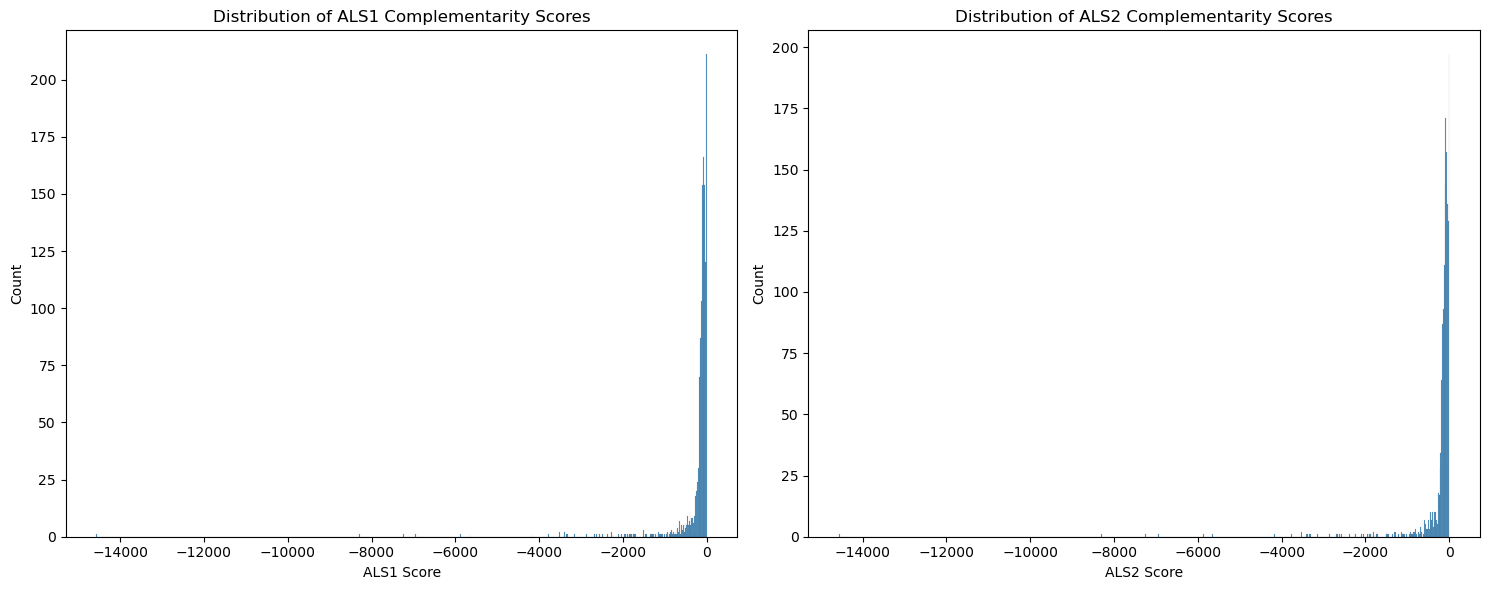

In [106]:
# Visualize ALS scores distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=enriched_overlaps_df, x='current_exon_als1_score', ax=ax1)
ax1.set_title('Distribution of ALS1 Complementarity Scores')
ax1.set_xlabel('ALS1 Score')

sns.histplot(data=enriched_overlaps_df, x='current_exon_als2_score', ax=ax2)
ax2.set_title('Distribution of ALS2 Complementarity Scores')
ax2.set_xlabel('ALS2 Score')

plt.tight_layout()
plt.show()

In [107]:
enriched_overlaps_df["groupID"] = enriched_overlaps_df["dexseq_name"].str.split(':').str[0]
n_sel = 100

In [108]:
enriched_overlaps_df = enriched_overlaps_df.sort_values('current_exon_als1_score', ascending=False)

In [110]:
enriched_overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_als1_score,current_exon_als2_score,neighboring_exons_analysis,groupID
27,E003,539,chr9:35100743-35101089,ENSG00000005238.19:E003,chr9,-3216.0,0.0,-0.249204,0.0,-3.2160,4.0,2.0,"{'E002': {'als1_score': -13.0, 'als2_score': -...",ENSG00000005238.19
26,E003,758,chr9:35101709-35101904,ENSG00000005238.19:E003,chr9,-2325.5,0.0,-0.249204,0.0,-2.3255,4.0,2.0,"{'E002': {'als1_score': -13.0, 'als2_score': -...",ENSG00000005238.19
8664,E013,111,chr2:229791123-229791325,ENSG00000196290.15:E013,chr2,28895847.0,0.0,-0.000518,0.0,28895.8470,3.0,1.0,"{'E013': {'als1_score': 3.0, 'als2_score': 1.0...",ENSG00000196290.15
9185,E055,418,chr9:128617727-128618134,ENSG00000197694.15:E055,chr9,-10003.0,0.0,0.082708,0.0,-10.0030,3.0,2.0,"{'E055': {'als1_score': 3.0, 'als2_score': 2.0...",ENSG00000197694.15
5126,E014,1035,chr1:67430175-67430363,ENSG00000142864.14:E014,chr1,-110.5,0.0,0.193468,0.0,-0.1105,3.0,2.0,"{'E014': {'als1_score': 3.0, 'als2_score': 2.0...",ENSG00000142864.14


In [109]:
n_sel = 100 
sel_genes = enriched_overlaps_df["groupID"][:n_sel]

In [111]:
import mygene

# Initialize mygene client
mg = mygene.MyGeneInfo()

# Remove version numbers from ENSEMBL IDs
sel_genes_no_version = [id.split('.')[0] for id in sel_genes]

# Query the gene symbols
results = mg.querymany(sel_genes_no_version, scopes='ensembl.gene', fields='symbol', species='human')

# Create a dictionary mapping ENSEMBL IDs to symbols
gene_map = {res['query']: res.get('symbol', 'Not found') for res in results}

gene_symbols = [gene_map[ensembl_id.split('.')[0]] for ensembl_id in sel_genes]

ensembl_to_symbol = dict(zip(sel_genes, gene_symbols))

# # Print results
# for ensembl, symbol in ensembl_to_symbol.items():
#     print(f"{ensembl}: {symbol}")

10 input query terms found dup hits:	[('ENSG00000005238', 2), ('ENSG00000196290', 10), ('ENSG00000168036', 2), ('ENSG00000184009', 3), ('


In [112]:
print(gene_symbols)

['ATOSB', 'ATOSB', 'NIF3L1', 'SPTAN1', 'SERBP1', 'RPS11', 'IARS1', 'CNIH2', 'CTNNB1', 'UBE2D3', 'YIF1A', 'ACTG1', 'ARMC6', 'ATXN2L', 'APEH', 'OCIAD1', 'OGT', 'SCAP', 'CTNNB1', 'MAPK1IP1L', 'NLE1', 'NIF3L1', 'EXOSC2', 'GAS5', 'HNRNPA1', 'ACTG1', 'EEF1A1', 'FMR1', 'TLE3', 'TTPAL', 'DIAPH1', 'ZFPL1', 'SCAP', 'SHMT2', 'MRPL55', 'GAS5', 'FLII', 'CERS2', 'PHGDH', 'SMIM30', 'HBP1', 'SMIM29', 'PSIP1', 'DCTN2', 'ATP5IF1', 'CPSF7', 'ACLY', 'FUS', 'RPL15', 'DNAH12', 'PSRC1', 'DALRD3', 'RPL29', 'ARFIP2', 'Not found', 'TNS2-AS1', 'GAS5', 'GPS1', 'NDUFB9', 'BET1L', 'UBC', 'ACTG1', 'CALM1', 'CBX1', 'NDUFAF7', 'UCHL1', 'WLS', 'SRRM2', 'H3-3B', 'EIF4A3', 'PCK2', 'APRT', 'EBNA1BP2', 'CREB3L4', 'RPL6P27', 'OCIAD1', 'PKN1', 'GPX4', 'P4HB', 'FARSA', 'CCNB1IP1', 'FUS', 'PCNP', 'ATP6V0B', 'NIF3L1', 'NIF3L1', 'NIF3L1', 'NIF3L1', 'MAGED1', 'NIF3L1', 'PRRC2C', 'SEC11A', 'SLC16A1', 'QARS1', 'NIF3L1', 'PRRC2C', 'FUS', 'PSRC1', 'NIF3L1', 'NIF3L1']
